<a href="https://colab.research.google.com/github/sgcs11/Yeardream_AI/blob/master/%EB%8D%B0%EC%9D%B4%EC%BD%98/hand_gesture/220310_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 손동작 분류 경진대회 베이스라인
이번 대회는 주어진 센서 데이터를 통해 손동작을 분류하는 경진대회입니다. 

언뜻보면 간단해 보이지만 처음 데이터 분석을 접하시는 분들에게는 어디부터 어떻게 시작해야 하는지 막막하실 겁니다.

# 누구나 할 수 있는 데이터 분석
딥러닝, 머신러닝, 모델, 학습, 회귀분석 .... 다 몰라도 괜찮습니다!

누구나 할 수 있는 방식으로 간단하게 데이터 분석 & 예측을 진행해보겠습니다.

# 데이터 불러오기
먼저 분석하려는 데이터를 작업장으로 가져오는 작업이 필요합니다.

이를 위해서 파이썬 라이브러리 중 하나인 Pandas를 이용합니다.

pandas 라이브러리는 엑셀과 같은 행과 열로 이루어진 테이블(table) 형식의 데이터를 편하게 다루도록 해주는 라이브러리입니다.

데이터 분석에는 반드시 사용된다고 해도 과언이 아닌 라이브러리이니, 시간이 날때마다 공부해둡시다.

In [8]:
data_dir='/content/drive/MyDrive/Colab Notebooks/Dacon_contest/hand_gesture/data'

In [82]:
# 코랩 드라이브를 마운트합니다.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [84]:
# csv 형식으로 된 데이터 파일을 읽어옵니다. 
train = pd.read_csv(os.path.join(data_dir,'train.csv'))

# 데이터의 최상단 5줄을 표시합니다. 
train.head()

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,...,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,...,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,...,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,...,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,...,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2


In [85]:
#target은 0, 1, 2, 3이 존잰

출력된 데이터의 모양을 살펴보면 총 34개의 열(column)이 존재하는 것을 확인할 수 있습니다.

데이터를 자세히 살펴보는 것은 EDA 글을 통해 더 자세히 배워봅시다.

여기에서는 분석 방법에 초점을 맞추겠습니다.

# 결측치 확인
결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [86]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


결측치 처리

이번 데이터에는 결측치가 존재하지 않습니다. 

# 데이터 분리

학습 데이터에서 target 데이터를 분리합니다.

In [87]:
train_X = train.drop(['id','target'],axis=1)
train_y = train.target

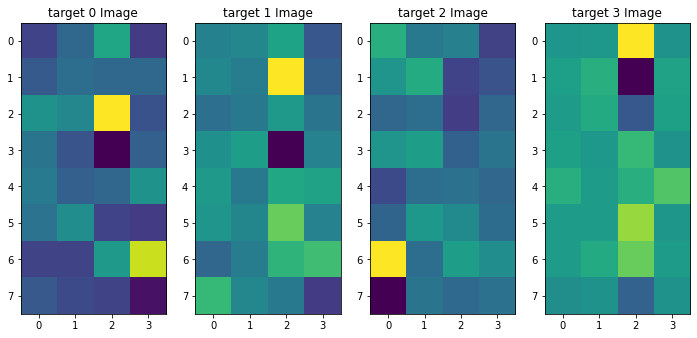

In [88]:
f, a = plt.subplots(1, 4, figsize = (12, 6))
for i in range(4) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(train_X.iloc[i]).reshape(8, 4))

In [89]:
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

## EDA

### CNN에서 활용할 수 있게 데이터 차원 변경

In [90]:
train_X = torch.tensor(np.array(train_X).reshape(-1,1,8,4), dtype=torch.float32)
valid_X = torch.tensor(np.array(valid_X).reshape(-1,1,8,4), dtype=torch.float32)

### Multiclass를 위한 one hot encoding

In [91]:
ohe = OneHotEncoder(sparse = False)

In [92]:
train_y = ohe.fit_transform(np.array(train_y).reshape(-1,1))
valid_y = ohe.fit_transform(np.array(valid_y).reshape(-1,1))

## DataSet

In [93]:
import torch
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

## DataLoader

In [94]:
train_dataset = BasicDataset(train_X, train_y)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=32, num_workers=8, shuffle=True)

In [95]:
valid_dataset = BasicDataset(valid_X, valid_y)
valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=32, num_workers=8, shuffle=True)

## Train

In [96]:
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=8, kernel_size=2, padding=1),
              nn.BatchNorm2d(8),
              nn.ELU(),
              nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, padding=1),
              nn.MaxPool2d(2),
              nn.ELU(),
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
              nn.BatchNorm2d(32),
              nn.ELU(),
              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
              nn.BatchNorm2d(32),
              nn.ELU(),
              nn.AdaptiveAvgPool2d((1,1)),
          )

    self.fc1 = nn.Sequential(
        nn.Linear(8 * 4, 16),
        nn.ReLU(),
        nn.Linear(16, 4),
        # nn.Softmax(dim=1)
    )
  
  def forward(self, x):
    # print("연산 전", x.size())
    x = self.conv1(x)
    # print("conv1 연산 후",x.size())
    x = x.view(-1, 8 * 4)
    # print("차원 감소 후", x.size())
    x = self.fc1(x)
    # print("fc1 연산 후", x.size())
    return F.softmax(x)
  
  def predict(self, x):
    output = self.forward(x)
    return output.argmax(dim=1, keepdim=True)

cnn = CNN()
output = cnn(torch.randn(32, 1, 8, 4))  # Input Size: (10, 1, 8, 4)

In [98]:
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ELU(alpha=1.0)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ELU(alpha=1.0)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)


In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

In [100]:
train_y.shape

(1868, 4)

In [102]:
model.train()  # 학습을 위함

for epoch in range(100):
  correct = 0
  for index, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()  # 기울기 초기화
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    gt = np.argmax(target, axis=1)
    correct += pred.eq(gt.view_as(pred)).sum().item()
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

    if index % 100 == 0:
      print("loss of {} epoch: {}".format(epoch, loss.item()))

  print("train Accuracy : ", 100. * correct/len(train_loader.dataset))

loss of 0 epoch: 0.9737563785165548
train Accuracy :  81.63811563169165
loss of 1 epoch: 1.0518886428326368
train Accuracy :  81.69164882226981
loss of 2 epoch: 0.9482188690453768
train Accuracy :  82.92291220556746
loss of 3 epoch: 0.9295967109501362
train Accuracy :  83.02997858672377
loss of 4 epoch: 1.1128506194800138
train Accuracy :  83.02997858672377
loss of 5 epoch: 1.021449964493513
train Accuracy :  82.86937901498929
loss of 6 epoch: 1.0309418961405754
train Accuracy :  84.20770877944325
loss of 7 epoch: 0.8951628636568785
train Accuracy :  84.85010706638116
loss of 8 epoch: 0.9113015625625849
train Accuracy :  84.42184154175588
loss of 9 epoch: 0.9499757811427116
train Accuracy :  85.33190578158458
loss of 10 epoch: 0.9322354458272457
train Accuracy :  84.95717344753747
loss of 11 epoch: 0.927167309448123
train Accuracy :  84.74304068522484
loss of 12 epoch: 0.9055701028555632
train Accuracy :  84.90364025695932
loss of 13 epoch: 0.8704783916473389
train Accuracy :  85.11777

In [103]:
model.eval()  # test case 학습 방지를 위함
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in valid_loader:
    output = model(data)
    test_loss += criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    target = np.argmax(target, axis=1).reshape(-1,1)
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))


Test set: Average loss: 13.2031, Accuracy: 404/467 (87%)



# 추론 

모델 학습이 완료 되었습니다! 

이제 test 데이터를 예측 해보아요!

In [104]:
test = pd.read_csv(os.path.join(data_dir,'test.csv'))
test.head()

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
0,1,0.067135,5.040383,-2.965405,-12.952880,-1.938465,-10.997802,1.853669,21.077862,7.963131,...,8.128448,5.871833,1.889536,-3.926719,0.929041,4.999071,-7.963270,4.044370,-1.993315,10.855771
1,2,6.890655,-12.010728,24.881907,38.943245,-4.757496,5.926453,7.923851,3.925545,4.012127,...,-7.941582,-27.106928,-16.940167,-11.169073,0.202975,6.846631,7.911875,-2.852819,56.028042,52.967175
2,3,-4.809695,0.962863,-1.893647,-6.168084,-3.948282,0.977219,12.960620,-9.048958,5.969053,...,-0.895094,-7.984137,-0.025761,2.981749,4.948704,-10.841968,-4.860024,-6.917495,2.842422,-3.081374
3,4,0.018158,-3.993114,12.001667,22.960746,-2.121793,-6.002385,2.173744,1.045248,1.073869,...,-10.084452,2.828070,0.903349,5.156367,40.827713,-1.160840,-1.215552,0.037914,-24.968873,-7.148603
4,5,-7.841592,-2.129997,7.872448,-8.953428,28.080007,-5.019895,-10.922551,-15.045833,-56.981894,...,-2.000975,-23.942689,-6.741350,0.831967,11.905613,3.106004,46.899363,3.001353,-17.881074,-6.882390


In [105]:
test_X = test.drop(['id'],axis=1)

In [106]:
test_X = torch.tensor(np.array(test_X).reshape(-1,1,8,4), dtype=torch.float32)

In [107]:
pred = model.predict(test_X)

In [108]:
pred

tensor([[0],
        [0],
        [1],
        ...,
        [2],
        [0],
        [3]])

# dacon 대회에 제출하기
이제 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [109]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv(os.path.join(data_dir,'sample_submission.csv'))
submission.head()

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [110]:
submission['target'] = pred

# 데이터가 잘 들어갔는지 확인합니다.
submission

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
...,...,...
9338,9339,3
9339,9340,1
9340,9341,2
9341,9342,0


In [111]:
submission.to_csv(os.path.join(data_dir,'submit.csv'),index=False)